LECTURE 2
## 9. Solutions

Search for `# TO DO:` in each block above and compare to the full code here.



### Solution 8.1

In [1]:
import pandas as pd

path = "sample_beer_lambert.csv"
# TO DO: read the CSV
df = pd.read_csv(path)

print(df.head())
print(df.info())
print(df.describe())

# TO DO: boolean mask and count
mask = df["absorbance_A"] > 0
count_positive = mask.sum()
print("rows with condition:", count_positive)

   concentration_mol_L  replicate  absorbance_A
0                0.000          1        0.0050
1                0.000          2       -0.0032
2                0.000          3        0.0017
3                0.002          1        0.2448
4                0.002          2        0.2401
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   concentration_mol_L  33 non-null     float64
 1   replicate            33 non-null     int64  
 2   absorbance_A         33 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 920.0 bytes
None
       concentration_mol_L  replicate  absorbance_A
count            33.000000  33.000000     33.000000
mean              0.010000   2.000000      1.196403
std               0.006423   0.829156      0.781941
min               0.000000   1.000000     -0.003200
25%               0.004000   1.000000   

---

### Solution 8.2

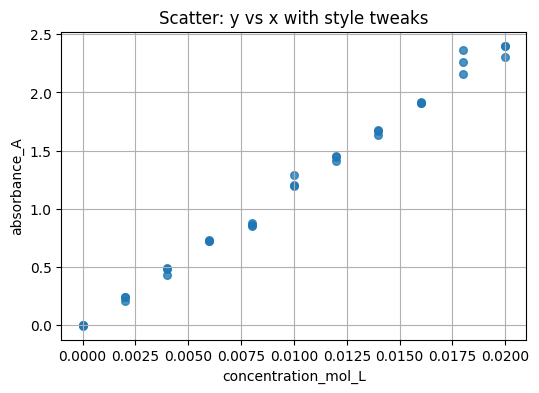

In [2]:
import matplotlib.pyplot as plt

xcol = "concentration_mol_L"
ycol = "absorbance_A"

# TO DO: style controls
point_size = 30
alpha_val  = 0.8
marker_sym = "o"

plt.figure(figsize=(6, 4))
plt.scatter(df[xcol], df[ycol], s=point_size, alpha=alpha_val, marker=marker_sym)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.title("Scatter: y vs x with style tweaks")
plt.grid(True)

---

### Solution 8.3

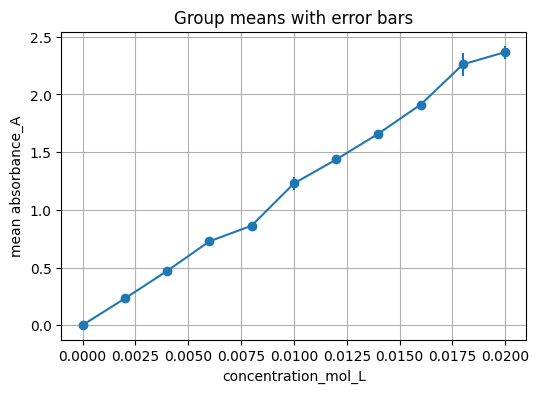

In [3]:
key_col = "concentration_mol_L"
val_col = "absorbance_A"

summary = (
    df.groupby(key_col)[val_col]
      .agg(["mean", "std", "count"])
      .reset_index()
)

x = summary[key_col].to_numpy()
y = summary["mean"].to_numpy()
# TO DO: standard deviation array
yerr = summary["std"].to_numpy()

plt.figure(figsize=(6, 4))
plt.errorbar(x, y, yerr=yerr, fmt="o-")
plt.xlabel(key_col)
plt.ylabel(f"mean {val_col}")
plt.title("Group means with error bars")
plt.grid(True)

---

### Solution 8.4

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use provided file if present
path = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/organic_synthesis_yields.csv" 

# TO DO: read CSV
df_y = pd.read_csv(path)
df_y.head()

,reaction_id,temperature_C,time_min,yield_percent
0,63,80,50,3.0
1,177,70,170,28.6
2,34,65,180,22.6
3,167,105,230,51.7
4,94,65,130,24.9


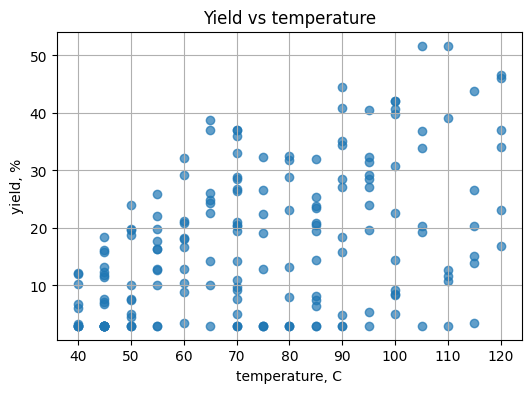

In [5]:
# TO DO: scatter temperature vs yield
plt.figure(figsize=(6, 4))
plt.scatter(df_y["temperature_C"], df_y["yield_percent"], alpha=0.7)
plt.xlabel("temperature, C")
plt.ylabel("yield, %")
plt.title("Yield vs temperature")
plt.grid(True)

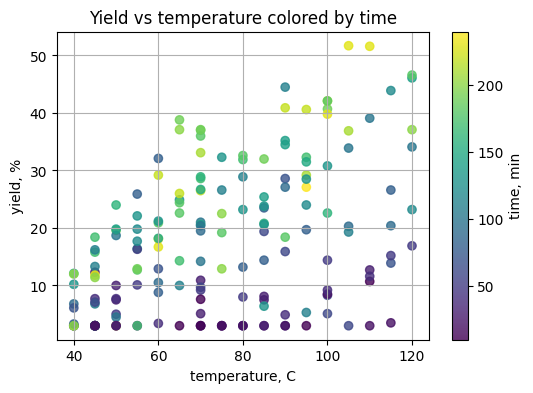

In [6]:
# TO DO: color by time, choose a colormap
plt.figure(figsize=(6, 4))
plt.scatter(df_y["temperature_C"], df_y["yield_percent"],
            c=df_y["time_min"], cmap="viridis", alpha=0.8)
plt.colorbar(label="time, min")
plt.xlabel("temperature, C")
plt.ylabel("yield, %")
plt.title("Yield vs temperature colored by time")
plt.grid(True)

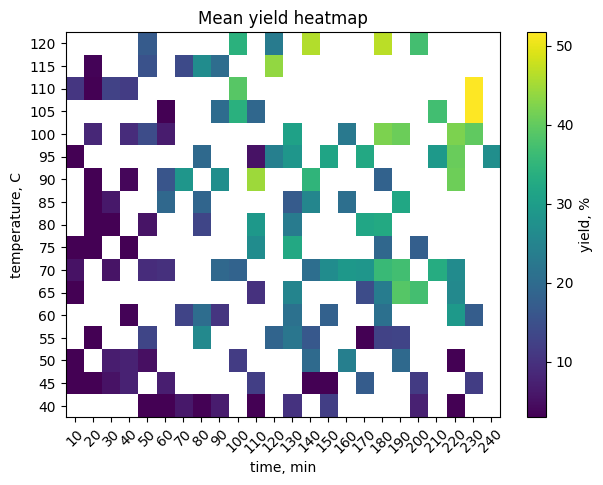

In [7]:
# TO DO: pivot and heatmap
pivot = df_y.pivot_table(index="temperature_C", columns="time_min",
                         values="yield_percent", aggfunc="mean")
plt.figure(figsize=(7, 5))
plt.imshow(pivot.to_numpy(), aspect="auto", origin="lower")
plt.colorbar(label="yield, %")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45)
plt.xlabel("time, min")
plt.ylabel("temperature, C")
plt.title("Mean yield heatmap")
plt.grid(False)

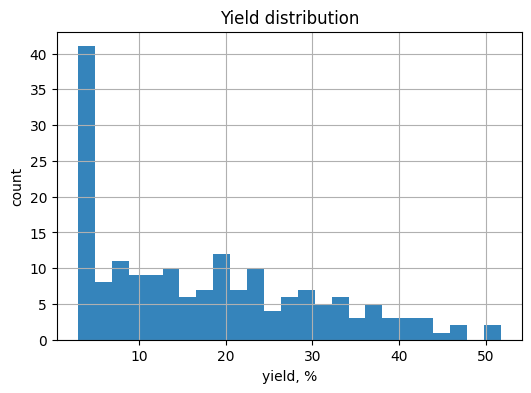

In [8]:
# TO DO: histogram with chosen bins
plt.figure(figsize=(6, 4))
plt.hist(df_y["yield_percent"], bins=25, alpha=0.9)
plt.xlabel("yield, %")
plt.ylabel("count")
plt.title("Yield distribution")
plt.grid(True)

---

### Solution 8.5

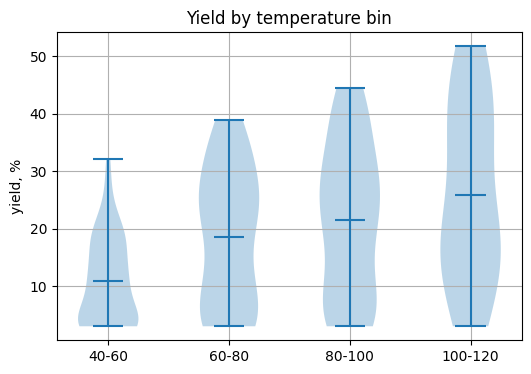

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TO DO: define bins and labels
bins = [40, 60, 80, 100, 120]
labels = ["40-60", "60-80", "80-100", "100-120"]

df_y = df_y.copy()
df_y["temp_bin"] = pd.cut(df_y["temperature_C"], bins=bins, labels=labels, include_lowest=True)

# TO DO: build groups and draw plot
groups = [grp["yield_percent"].to_numpy() for _, grp in df_y.groupby("temp_bin")]

plt.figure(figsize=(6, 4))
plt.violinplot(groups, showmeans=True)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel("yield, %")
plt.title("Yield by temperature bin")
plt.grid(True)

```python
# Uncomment to generate:
# rng = np.random.default_rng(42)
# n = 180
# temperature_C = rng.choice(np.arange(40, 121, 5), size=n, replace=True, p=np.linspace(2, 1, 17) / np.linspace(2, 1, 17).sum())
# time_min = rng.choice(np.arange(10, 241, 10), size=n, replace=True, p=np.linspace(2, 1, 24) / np.linspace(2, 1, 24).sum())
# temp_scale = (temperature_C - 30) / 60.0
# time_scale = time_min / 180.0
# base = 100 * (1 - np.exp(-temp_scale)) * (1 - np.exp(-time_scale))
# noise_normal = rng.normal(0, 7, size=n)
# noise_neg = -rng.gamma(shape=1.2, scale=4, size=n)
# yield_percent = np.clip(np.round(base + noise_normal + noise_neg, 1), 3, 96)
# df_new = pd.DataFrame({"reaction_id": np.arange(1, n + 1),
#                        "temperature_C": temperature_C,
#                        "time_min": time_min,
#                        "yield_percent": yield_percent}).sample(frac=1, random_state=123).reset_index(drop=True)
# df_new.to_csv("organic_synthesis_yields.csv", index=False)
```